# INFO-6153 - Natural Language Processing 2     
## Project 1 - GameSentiment: Analyzing Player Emotions and Feedback     
**Professor:** Dr. Gholamiangonabadi      
**Project:**  Project 1 - GameSentiment: Analyzing Player Emotions and Feedback      
**Student:** Cassio Santanna  

**Objective:** This rubric outlines the criteria for evaluating the student's performance in the course project 1.    
The total points for the project are 100. This will be divided by 5 for the grade.


---


## Project Overview

This project aims to perform sentiment analysis on Twitter data related to various video games. It involves cleaning and preprocessing textual data, followed by training multiple deep learning models to predict sentiments such as Positive, Negative, Neutral, and Irrelevant.     
The primary models used in this project include Feedforward Neural Networks (FFNN), GRU (Gated Recurrent Unit), and BiLSTM (Bidirectional Long Short-Term Memory), with different optimization algorithms (SGD, Adam, and Adagrad) to determine the most effective approach for sentiment classification.

<br>

---




## Dataset definition:    

### Overview
This dataset contains user-generated text data related to video games, specifically focusing on sentiment analysis.      
It includes game titles, sentiment labels, and user comments. The dataset is useful for training machine learning models in natural language processing (NLP) tasks such as sentiment classification, text analysis, and game-related behavioral studies.

### Dataset Structure

- **Number of Rows:** 74,681  
- **Number of Columns:** 4  
- **File Format:** CSV  
- **Data Types:** Mixed (Integer, String)  

### Columns Description

#### 1. **Game ID** (`2401`)
- **Type:** Integer  
- **Description:** A unique numerical identifier associated with each game.  

#### 2. **Game Title** (`Borderlands`)
- **Type:** String  
- **Description:** Name of the video game being referenced in the user comment.  
- **Unique Values:** 32 (e.g., *Borderlands*, *TomClancysRainbowSix*, etc.)  

#### 3. **Sentiment Label** (`Positive`)
- **Type:** String (Categorical)  
- **Description:** The sentiment classification of the comment.  
- **Possible Values:** `Positive`, `Negative`, `Neutral`, `Mixed`  
- **Most Frequent Label:** `Negative` (22,542 occurrences)  

#### 4. **User Comment** (`im getting on borderlands and i will murder you all ,`)
- **Type:** String  
- **Description:** A text snippet containing user-generated content related to the game.  
- **Total Non-Null Values:** 73,995  
- **Unique Comments:** 69,490  


<hr>

<br>

### Import libs

In [1]:
import re
import random
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Flatten, GRU, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)

#### Load SpaCy

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

#### Set seed

In [3]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#### Load dataset

In [4]:
# Load dataset
file_path = "games.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError("CSV file not found!")

# Read CSV file and define column names
df = pd.read_csv(file_path, header=None, names=["ID", "Games", "Sentiment", "Content"])
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (74682, 4)


,ID,Games,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### Basic dataset informatitons

In [5]:
print(f"The dtypes of the dataset:")
df.dtypes

The dtypes of the dataset:


,0
ID,int64
Games,object
Sentiment,object
Content,object


In [6]:
# dataset information
df.describe(include='all')

,ID,Games,Sentiment,Content
count,74682.000000,74682,74682,73996
unique,NaN,32,4,69491
top,NaN,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,NaN,2400,22542,172
mean,6432.586165,NaN,NaN,NaN
std,3740.427870,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN




## Cleaning Approach

**The cleaning process includes**:

- **Text Preprocessing:** Contractions are expanded, URLs and emojis are removed, and punctuation is normalized.
- **Text Normalization:** Text is converted to lowercase, extra spaces are removed, and non-ASCII characters are eliminated.
- **Tokenization & Lemmatization:** Using SpaCy, stop words and punctuation are removed, and each word is lemmatized to its base form, ensuring more meaningful features for the model.
- **Data Filtering:** Unwanted games and companies are removed from the dataset, and missing or duplicated values are dropped.


<br>

<hr>

<br>

In [7]:
# Remove unwanted games/companies
games_to_remove = ['Microsoft', 'Google', 'Amazon', 'HomeDepot', 'Facebook', 'johnson&johnson', 'Nvidia', 'PlayStation5(PS5)', 'Xbox(Xseries)']
df = df[~df["Games"].isin(games_to_remove)]
print(f"Removed: {games_to_remove}\n\n")

print(f"Dataset shape aftner removing incompative names: {df.shape}")
df.head()

Removed: ['Microsoft', 'Google', 'Amazon', 'HomeDepot', 'Facebook', 'johnson&johnson', 'Nvidia', 'PlayStation5(PS5)', 'Xbox(Xseries)']


Dataset shape aftner removing incompative names: (53718, 4)


,ID,Games,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
# Analyzes missing and duplicated values
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values ,
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

print('Missing and duplicated values before cleaning:')
show_details(df)

Missing and duplicated values before cleaning:


,ID,Games,Sentiment,Content
Missed_Values,0.000000,0.000000,0.000000,456.000000
Missed_Values %,0.000000,0.000000,0.000000,0.008489
Duplicated values,1938.000000,1938.000000,1938.000000,1938.000000
Duplicated values %,0.036077,0.036077,0.036077,0.036077


In [9]:
# Drop duplicates and missing values
df = df.drop_duplicates().dropna()
print('Missing and duplicated values after cleaning:\n')
show_details(df)

Missing and duplicated values after cleaning:



,ID,Games,Sentiment,Content
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [10]:
# Cleaning text
def clean_text(text):
    # Expand common contractions
    contractions = {
        "won't": "will not", "can't": "can not", "don’t": "do not", "shouldn’t": "should not",
        "needn’t": "need not", "hasn’t": "has not", "haven’t": "have not", "weren’t": "were not",
        "mightn’t": "might not", "didn’t": "did not", "n’t": " not", "’re": " are", "’s": " is",
        "’d": " would", "’ll": " will", "’ve": " have", "’m": " am",
        "im": "i am", "Im": "I am"
    }
    for key, value in contractions.items():
        text = text.replace(key, value)

    text = re.sub(r"https?://\S+|www\.\S+", "", text) # Remove URLs
    text = re.sub(r"[^\w\s.,!?'\-]", "", text) # Remove only special characters, keeping those useful for SpaCy
    text = re.sub(r"[!]{2,}", "!", text) # Normalize repeated punctuation
    text = re.sub(r"[?]{2,}", "?", text)
    text = re.sub(r"[.]{2,}", ".", text)
    text = text.replace("\n", " ") # Remove unknown tokens and newlines
    text = text.lower() # Convert to lowercase
    text = re.sub(r"[ ]+", " ", text).strip() # Remove extra spaces
    text = re.sub(r"[^\x00-\x7F]+", "", text) # Remove emojis

    return text

In [11]:
cleaned_text = clean_text(random.choice(df['Content']))
cleaned_text

'the russian bots tighten up battlefield 1'

In [12]:
df['cleaned_content'] = df['Content'].apply(clean_text)
df.head(3)

,ID,Games,Sentiment,Content,cleaned_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,i am getting on borderlands and i will murder ...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,i am getting on borderlands and i will kill yo...


In [13]:
print(f'The number of unique Games : {len(df.Games.unique())}')
games = df.Games.value_counts()
games.to_frame()

The number of unique Games : 23


,count
Games,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291
ApexLegends,2278


In [14]:
print(f'Unique values of Sentiment : {len(df.Sentiment.unique())}')
print(df.Sentiment.unique())

Unique values of Sentiment : 4
['Positive' 'Neutral' 'Negative' 'Irrelevant']


## **Visualizations**
This section presents the various visualizations created to explore and analyze the dataset for sentiment analysis of Twitter content related to video games.    
 The visualizations are categorized based on sentiment distribution, game distribution, word clouds, and sentiment comparisons.

### **Distribution of Tweets by Game**
- **Objective**: Visualize the distribution of tweets across different games.

- **Description**: A horizontal bar chart was created to show the top 10 games by the number of tweets in the dataset. The chart uses the 'viridis' color palette for visual appeal, and annotations are included to display the exact tweet counts at the end of each bar.

- **Findings**: The visualization provides a clear understanding of which games are most discussed on Twitter within the dataset. Games with higher tweet counts appear more prominently in the chart.

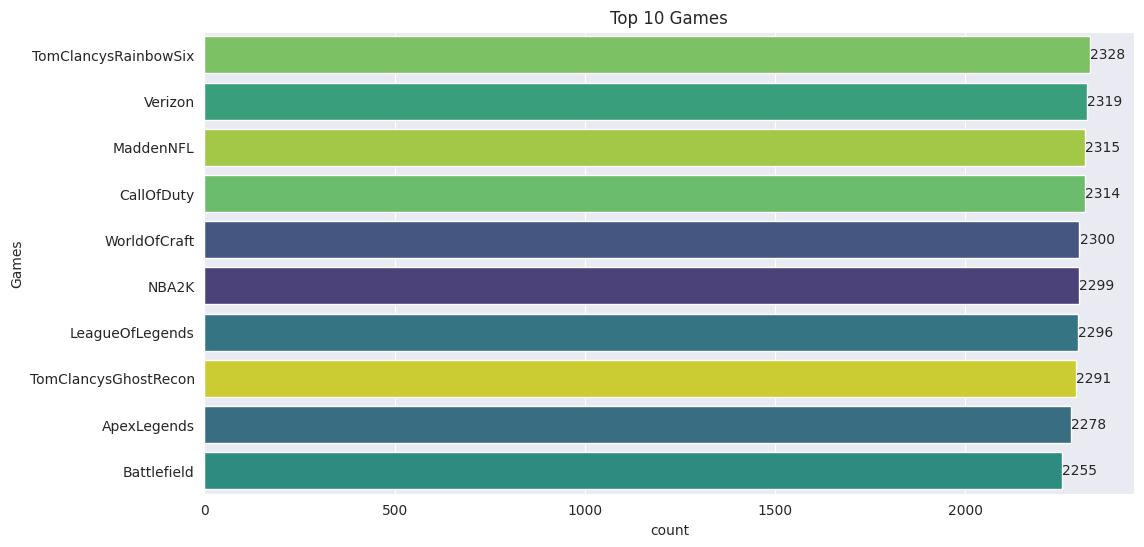

In [15]:
# Tweets distribution by games
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
top_10_games = df['Games'].value_counts().index[:10]
ax = sns.countplot(data=df, y='Games', palette='viridis', hue='Games', order=top_10_games)
plt.title('Top 10 Games')

# Annotate the total count at the end of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2),
                va='center', ha='left', fontsize=10)

plt.show()

### **Sentiment Distribution**    
- **Objective**: Analyze the distribution of sentiment labels across the dataset.

- **Description**: A countplot was generated to visualize the distribution of different sentiment categories: Positive, Negative, Neutral, and Irrelevant. The color palette used was 'viridis'.

- **Findings**: This plot provides an overview of sentiment distribution within the dataset. It allows for quick insights into the overall sentiment trend, showing how prevalent each sentiment is.

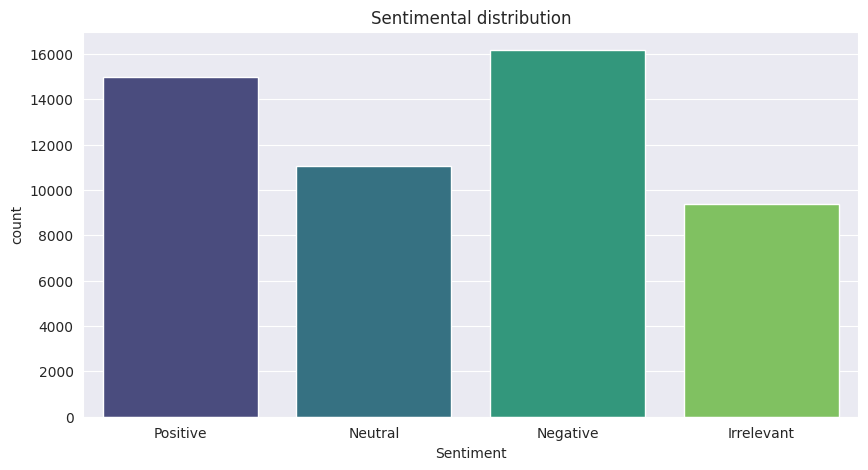

In [16]:
# Sentimental distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Sentiment', palette='viridis', hue='Sentiment')
plt.title('Sentimental distribution')
plt.show()

### **Comparison between Games and Sentiments**   
- **Objective**: Explore how sentiments are distributed across different games.

- **Description**: A stacked countplot was produced to compare sentiments between various games. The 'viridis' color palette was applied, and the x-axis shows different games while the sentiment is represented by hue. The chart’s x-axis labels were rotated to improve readability.

- **Findings**: The visualization offers an in-depth comparison of sentiment distribution per game. It highlights the sentiment tendencies for each game and reveals any imbalances in the sentiment classifications.

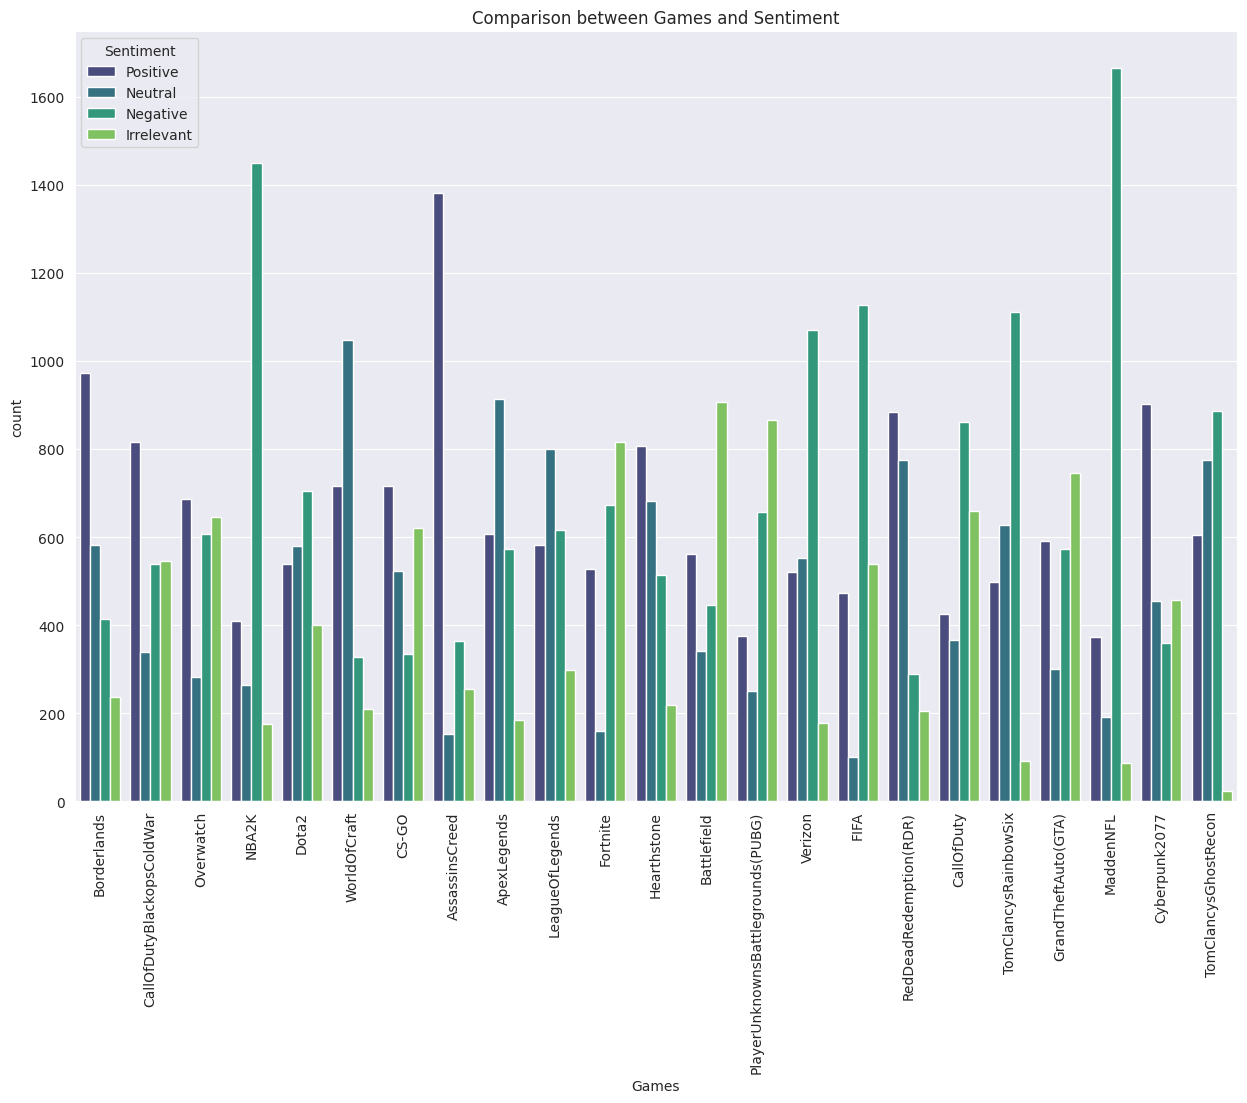

In [17]:
# Comparison between GAmes and Sentiment
plt.figure(figsize=(15, 10))
sns.countplot(data=df, x='Games', hue='Sentiment', palette='viridis')
plt.title('Comparison between Games and Sentiment')
plt.xticks(rotation=90)
plt.show()

### **Word Clouds for Each Sentiment Category**    
- **Objective**: Display the most frequent terms in each sentiment category to gain insights into the language used.

- **Description**: Four separate word clouds were generated for the following sentiment categories: Negative, Positive, Irrelevant, and Neutral. Each word cloud was generated by combining all tweets belonging to that sentiment.

- **Findings**: The word clouds visually represent the most commonly used words in each sentiment category. For example, the "Negative" sentiment word cloud likely includes words associated with frustration or dissatisfaction, while the "Positive" sentiment word cloud would highlight words that express excitement or approval.

In [18]:
# word clouds for each sentiment separately
def plot_word_clouds(data, sentiment, title):
    sentiment_texts = ' '.join(data.loc[data['Sentiment'] == sentiment, 'Content'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{title}: {sentiment}", fontsize=14)
    plt.show()

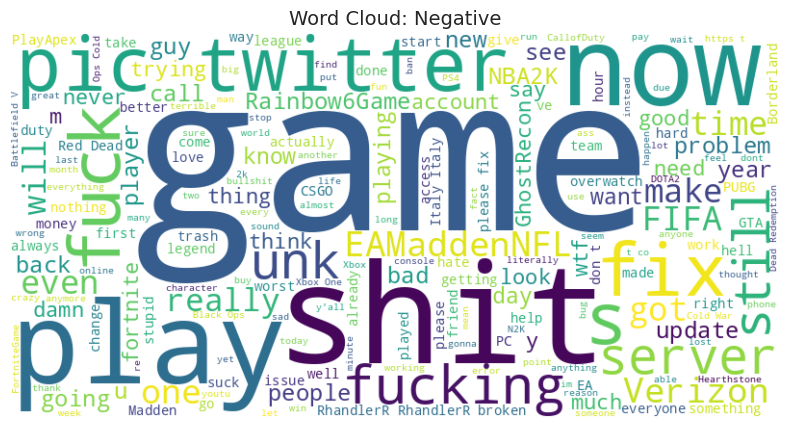

In [19]:
plot_word_clouds(df, "Negative", "Word Cloud")

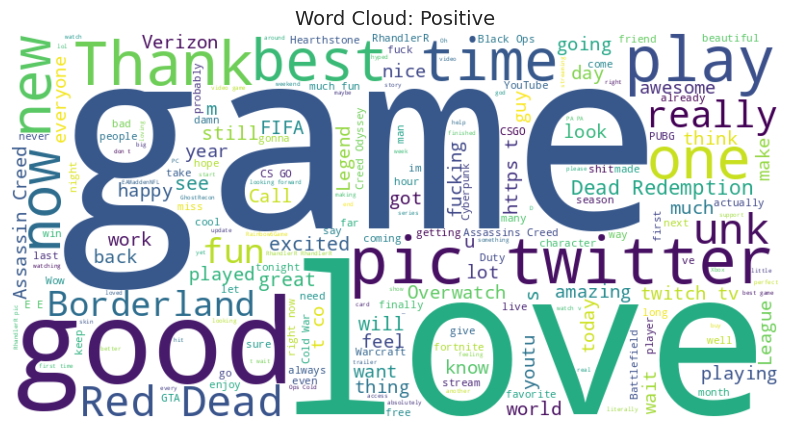

In [20]:
plot_word_clouds(df, "Positive", "Word Cloud")

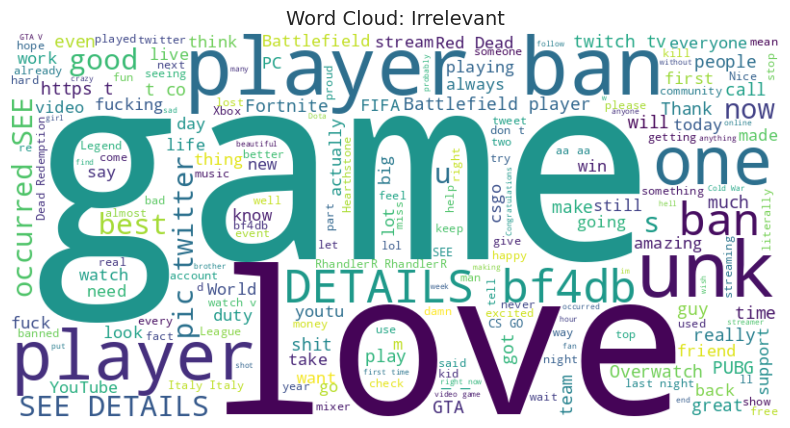

In [21]:
plot_word_clouds(df, "Irrelevant", "Word Cloud")

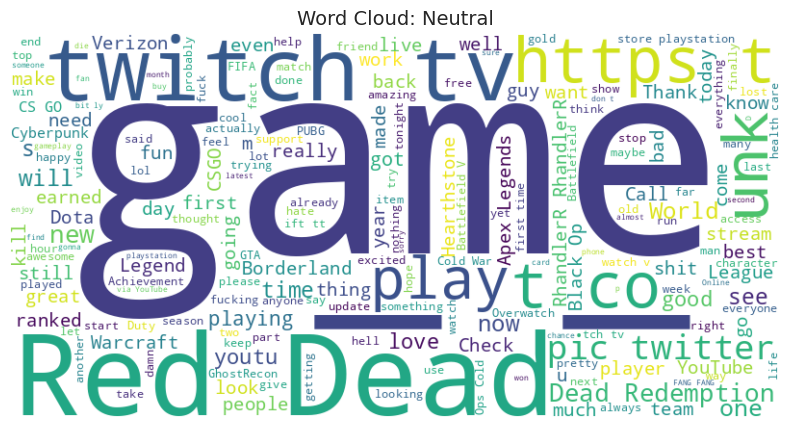

In [22]:
plot_word_clouds(df, "Neutral", "Word Cloud")

### **Sentiment Distribution in a Pie Chart**    
- **Objective**: Display the relative proportions of each sentiment label in the dataset.

- **Description**: A pie chart was created to show the distribution of sentiment categories across the dataset. The chart uses a 'viridis' color palette and includes labels and percentages for each sentiment category.

- **Findings**: The pie chart provides an easy-to-understand representation of sentiment proportions. It offers a quick, overall summary of how sentiments are distributed, highlighting the relative prevalence of each sentiment.

In [23]:
# Count of sentiments
count_sentiments = df.Sentiment.value_counts()
print(f'Count of sentiments:')
count_sentiments.to_frame().T

Count of sentiments:


Sentiment,Negative,Positive,Neutral,Irrelevant
count,16165,14968,11062,9365


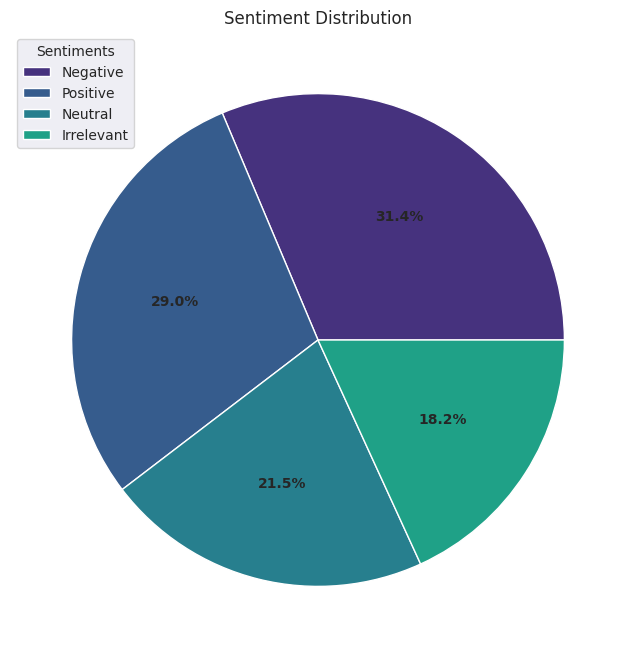

In [26]:
# Distribution of sentiments
plt.figure(figsize=(8, 8))
plt.pie(x = count_sentiments.values,
        labels=count_sentiments.keys(),
        autopct="%1.1f%%",
        textprops={"fontsize":10,"fontweight":"black"},
        colors=sns.color_palette("viridis"),
        labeldistance=None)
plt.legend(title="Sentiments", loc="upper left")
plt.title('Sentiment Distribution')
plt.show()


### **Sentiment Analysis by Game**    
- **Objective**: Visualize the sentiment distribution per game for detailed insights.

- **Description**: A pivot table was created to show the sentiment analysis for each game. This was followed by a styled table visualization that applies color gradients for Negative, Positive, and Irrelevant sentiments. The table formatting includes proper alignment and borders to enhance clarity.

- **Findings**: This visualization provides an in-depth breakdown of how sentiments are distributed across different games. It helps identify specific games with more negative or positive sentiment and highlights potential areas for further analysis.

In [ ]:
# Sentiment Analysis by Game
df_pivot = pd.crosstab(df.Sentiment, df.Games).T.reset_index()  # Convert index to column

styled_table = (
    df_pivot.style
    .set_caption("Sentiment Analysis by Game")  # Add title
    .background_gradient(subset=['Negative'], cmap='Reds')  # Color gradient
    .background_gradient(subset=['Positive'], cmap='Greens')
    .background_gradient(subset=['Irrelevant'], cmap='Blues')
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})  # Align text & add borders
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '14px')]},  # Center header text
        {'selector': 'td, th', 'props': [('width', '100px')]}  # Set equal column width
    ])
)

styled_table
# Reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

Sentiment,Games,Irrelevant,Negative,Neutral,Positive
0,ApexLegends,185,574,913,606
1,AssassinsCreed,256,365,153,1382
2,Battlefield,907,445,342,561
3,Borderlands,238,415,581,972
4,CS-GO,620,335,523,717
5,CallOfDuty,660,861,367,426
6,CallOfDutyBlackopsColdWar,545,540,340,817
7,Cyberpunk2077,457,360,456,902
8,Dota2,401,705,579,540
9,FIFA,538,1127,100,473


These visualizations contribute to a comprehensive understanding of the dataset and provide valuable insights into the sentiment trends across different games. Each plot serves as an analytical tool to guide further modeling and interpretation steps.

#### Split data into training and testing sets

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Sentiment'], test_size=0.2, random_state=SEED, stratify=df['Sentiment'])

In [ ]:
# Apply cleaning to train and test sets
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

#### Preprocessing with SpaCy

In [ ]:
# Apply preprocessing for lemma, remove stop words and ponctuations
def spacy_preprocessing(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# df['processed_content'] = df['cleaned_content'].apply(spacy_preprocessing)

In [ ]:
# Apply SpaCy preprocessing to train and test sets separately
X_train_processed = X_train_cleaned.apply(spacy_preprocessing)
X_test_processed = X_test_cleaned.apply(spacy_preprocessing)

In [ ]:
# Show an example of text processing
print("Original text example:")
print(X_train.iloc[0])
print("\nAfter cleaning:")
print(X_train_cleaned.iloc[0])
print("\nAfter SpaCy preprocessing:")
print(X_train_processed.iloc[0])

Original text example:
If the @ Tesla cybertruck is not in @ CyberpunkGame, I will be disappointed in @ elonmusk for the missed opportunity

After cleaning:
if the tesla cybertruck is not in cyberpunkgame, i will be disappointed in elonmusk for the missed opportunity

After SpaCy preprocessing:
tesla cybertruck cyberpunkgame disappoint elonmusk miss opportunity


#### Encode labels

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

#### Tokenize and pad sequences

In [ ]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_processed)
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

## FFNN Model with optimizers: SGD, ADAM, and ADAGRAD

In [ ]:
# Define optimizers
optimizer_classes = {'SGD': SGD, 'Adam': Adam, 'Adagrad': Adagrad}

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Training FFNN with SGD...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.3116 - loss: 1.3653 - val_accuracy: 0.3135 - val_loss: 1.3613
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.3225 - loss: 1.3607 - val_accuracy: 0.3135 - val_loss: 1.3599
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.3248 - loss: 1.3589 - val_accuracy: 0.3189 - val_loss: 1.3587
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.3277 - loss: 1.3574 - val_accuracy: 0.3265 - val_loss: 1.3575
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.3298 - loss: 1.3559 - val_accuracy: 0.3285 - val_loss: 1.3560


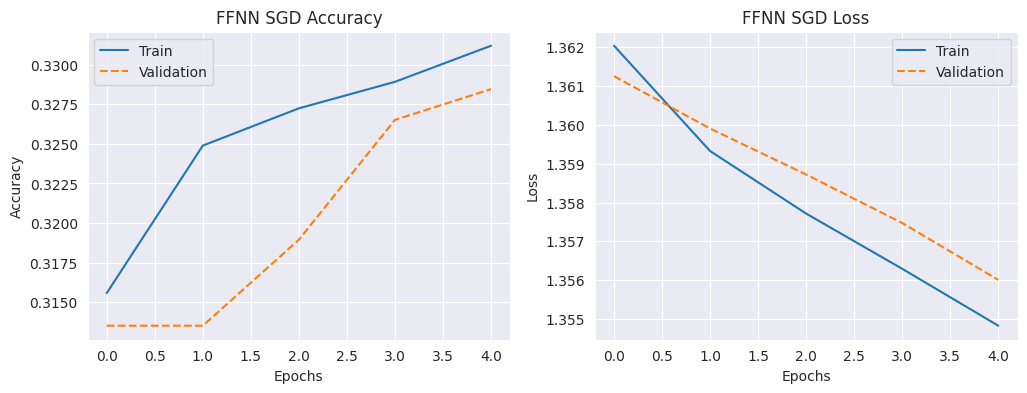

Training FFNN with Adam...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.4589 - loss: 1.1658 - val_accuracy: 0.7762 - val_loss: 0.6000
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8388 - loss: 0.4405 - val_accuracy: 0.8390 - val_loss: 0.4247
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9117 - loss: 0.2387 - val_accuracy: 0.8459 - val_loss: 0.4232
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.9364 - loss: 0.1682 - val_accuracy: 0.8470 - val_loss: 0.4417
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.9467 - loss: 0.1376 - val_accuracy: 0.8453 - val_loss: 0.4707


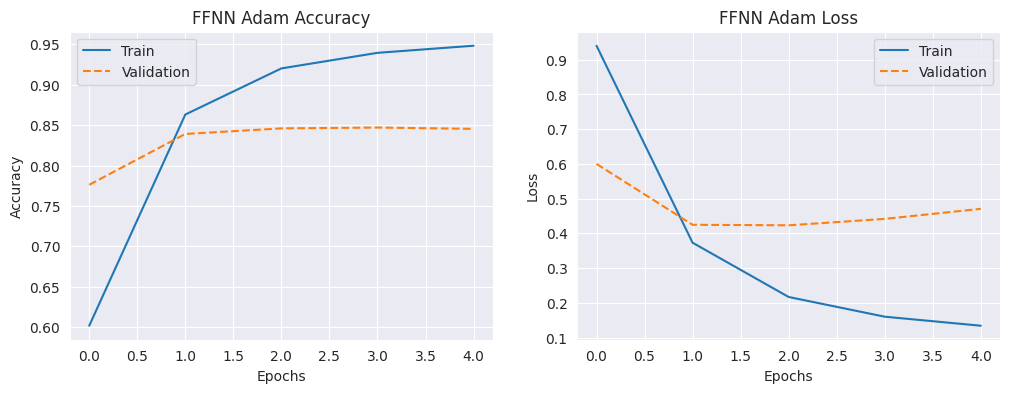

Training FFNN with Adagrad...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.3064 - loss: 1.3688 - val_accuracy: 0.3135 - val_loss: 1.3616
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.3128 - loss: 1.3624 - val_accuracy: 0.3135 - val_loss: 1.3610
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.3135 - loss: 1.3616 - val_accuracy: 0.3135 - val_loss: 1.3605
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.3173 - loss: 1.3609 - val_accuracy: 0.3135 - val_loss: 1.3600
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.3196 - loss: 1.3603 - val_accuracy: 0.3136 - val_loss: 1.3595


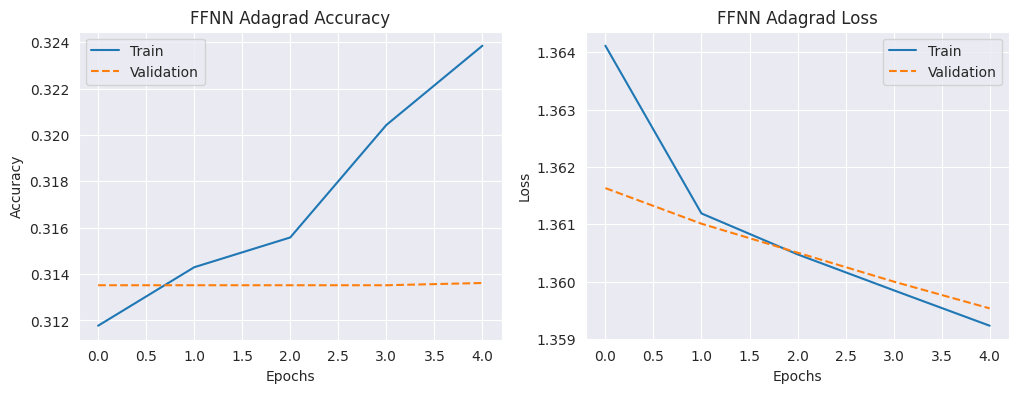

In [ ]:
# Train FFNN model
for name, opt_class in optimizer_classes.items():
    print(f"Training FFNN with {name}...")
    ffnn = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=max_len),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(y_train_cat.shape[1], activation='softmax')
    ])
    opt = opt_class()
    ffnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = ffnn.fit(
        X_train_pad, 
        y_train_cat, 
        epochs=10, 
        batch_size=64, 
        validation_data=(X_test_pad, y_test_cat), 
        verbose=1,
        callbacks=[early_stopping]
    )

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train")
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label="Validation")
    plt.title(f"FFNN {name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], linestyle='dashed', label="Validation")
    plt.title(f"FFNN {name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Model Evaluation and Its Outputs

**Feedforward Neural Network (FFNN):**   
Architecture: The FFNN consists of an embedding layer, a flatten layer, and two dense layers. It is trained with the Adam, SGD, and Adagrad optimizers.

**Best Accuracy:**     
 - Adam: 94.62% (Training accuracy), 84.58% (Validation accuracy)
 - SGD: 32.74% (Training accuracy), 32.63% (Validation accuracy)
 - Adagrad: 31.96% (Training accuracy), 31.36% (Validation accuracy)

<br>

## GRU Model with optimizers: SGD, ADAM, and ADAGRAD

Training GRU with SGD...
Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.3041 - loss: 1.3689 - val_accuracy: 0.3135 - val_loss: 1.3629
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.3127 - loss: 1.3640 - val_accuracy: 0.3135 - val_loss: 1.3629
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.3127 - loss: 1.3640 - val_accuracy: 0.3135 - val_loss: 1.3629
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.3127 - loss: 1.3640 - val_accuracy: 0.3135 - val_loss: 1.3629


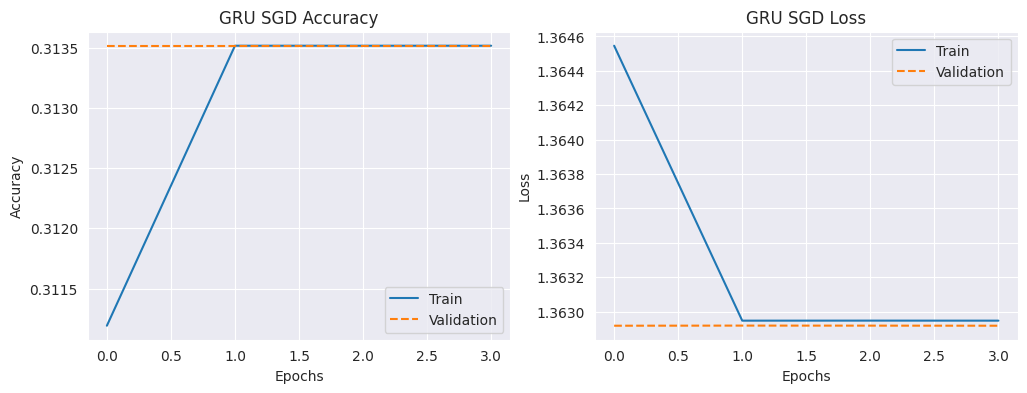

Training GRU with Adam...
Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.3066 - loss: 1.3659 - val_accuracy: 0.3135 - val_loss: 1.3668
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.3110 - loss: 1.3647 - val_accuracy: 0.3135 - val_loss: 1.3658
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.3116 - loss: 1.3645 - val_accuracy: 0.3135 - val_loss: 1.3654
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.3119 - loss: 1.3644 - val_accuracy: 0.3135 - val_loss: 1.3652
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.3119 - loss: 1.3643 - val_accuracy: 0.3135 - val_loss: 1.3653
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.3120 - loss: 1.3643 - val_accuracy: 0.3135 - val_loss: 1.3652
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 83s 90ms/step - accuracy: 0.3120 - loss: 1.3643 - val_accuracy: 0.3135 - val_loss: 1.3653


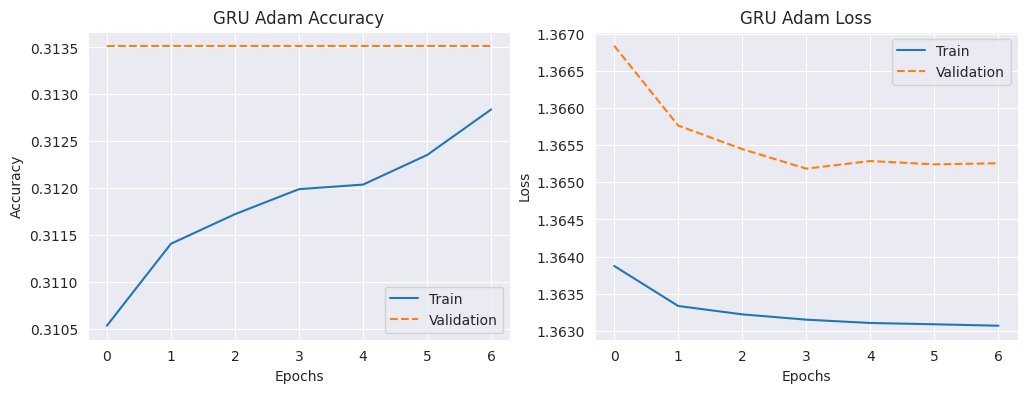

Training GRU with Adagrad...
Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.3075 - loss: 1.3774 - val_accuracy: 0.3135 - val_loss: 1.3650
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.3127 - loss: 1.3650 - val_accuracy: 0.3135 - val_loss: 1.3631
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.3127 - loss: 1.3639 - val_accuracy: 0.3135 - val_loss: 1.3628
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.3127 - loss: 1.3638 - val_accuracy: 0.3135 - val_loss: 1.3628
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - accuracy: 0.3127 - loss: 1.3638 - val_accuracy: 0.3135 - val_loss: 1.3628
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - accuracy: 0.3127 - loss: 1.3638 - val_accuracy: 0.3135 - val_loss: 1.3628
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.3127 - loss: 1.3638 - val_accuracy: 0.3135 - val_loss: 1.3628
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accur

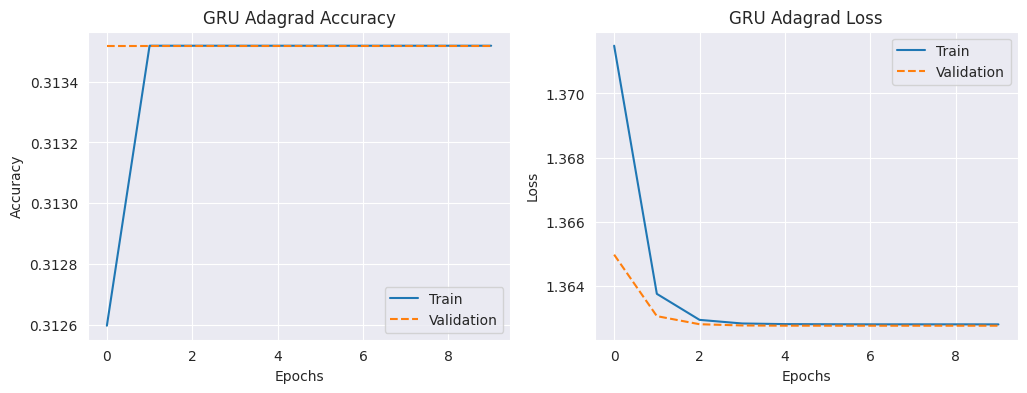

In [ ]:
# Train GRU model
for name, opt_class in optimizer_classes.items():
    print(f"Training GRU with {name}...")
    gru = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=max_len),
        GRU(128),
        Dense(y_train_cat.shape[1], activation='softmax')
    ])
    opt = opt_class()
    gru.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = gru.fit(
        X_train_pad, 
        y_train_cat, 
        epochs=10, 
        batch_size=64,
        validation_data=(X_test_pad, y_test_cat), 
        verbose=1,
        callbacks=[early_stopping]
    )

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train")
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label="Validation")
    plt.title(f"GRU {name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], linestyle='dashed', label="Validation")
    plt.title(f"GRU {name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Model Evaluation and Its Outputs

**GRU (Gated Recurrent Unit):**   
Architecture: The GRU model includes an embedding layer, a GRU layer, and a dense output layer.   
**Best Accuracy:**   
 - Adam: 31.20% (Training accuracy), 31.35% (Validation accuracy)
 - SGD: 31.27% (Training accuracy), 31.35% (Validation accuracy)
 - Adagrad: 31.27% (Training accuracy), 31.35% (Validation accuracy)  

The GRU model's performance is fairly consistent across optimizers, with limited improvement over the baseline accuracy.     

## BiLSTM model with optimizers: SGD, ADAM, and ADAGRAD

Training BiLSTM with SGD...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 67s 104ms/step - accuracy: 0.3034 - loss: 1.3700 - val_accuracy: 0.3135 - val_loss: 1.3617
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 64s 99ms/step - accuracy: 0.3127 - loss: 1.3627 - val_accuracy: 0.3135 - val_loss: 1.3608
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 86s 105ms/step - accuracy: 0.3137 - loss: 1.3618 - val_accuracy: 0.3135 - val_loss: 1.3599
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 64s 99ms/step - accuracy: 0.3172 - loss: 1.3608 - val_accuracy: 0.3155 - val_loss: 1.3589
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.3229 - loss: 1.3597 - val_accuracy: 0.3217 - val_loss: 1.3579


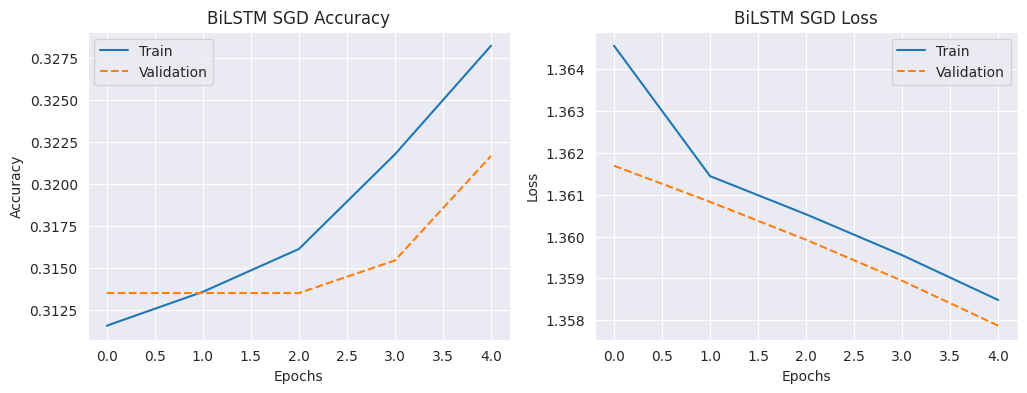

Training BiLSTM with Adam...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 86s 133ms/step - accuracy: 0.5334 - loss: 1.0709 - val_accuracy: 0.7581 - val_loss: 0.6374
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 90s 139ms/step - accuracy: 0.8134 - loss: 0.4917 - val_accuracy: 0.7987 - val_loss: 0.5335
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.8708 - loss: 0.3437 - val_accuracy: 0.8277 - val_loss: 0.4827
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - accuracy: 0.8981 - loss: 0.2687 - val_accuracy: 0.8392 - val_loss: 0.4810
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 89s 138ms/step - accuracy: 0.9101 - loss: 0.2310 - val_accuracy: 0.8384 - val_loss: 0.5084


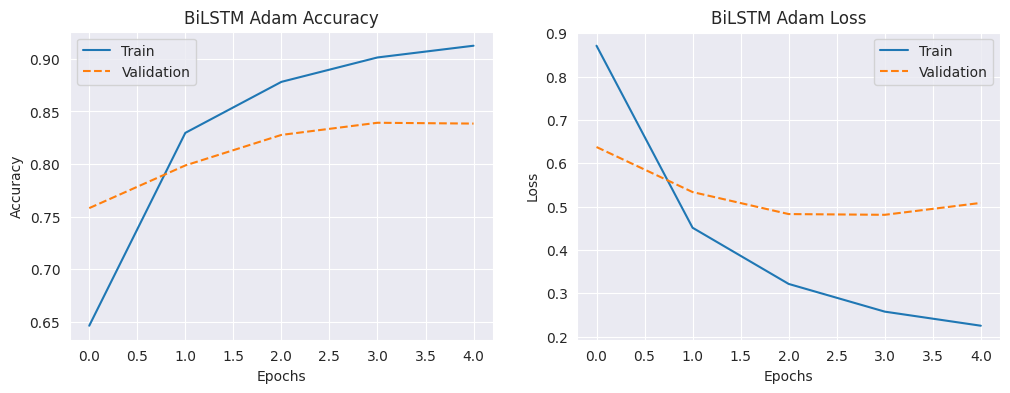

Training BiLSTM with Adagrad...
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 70s 108ms/step - accuracy: 0.2987 - loss: 1.3740 - val_accuracy: 0.3135 - val_loss: 1.3631
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 86s 114ms/step - accuracy: 0.3127 - loss: 1.3637 - val_accuracy: 0.3135 - val_loss: 1.3622
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.3127 - loss: 1.3631 - val_accuracy: 0.3135 - val_loss: 1.3618
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 80s 112ms/step - accuracy: 0.3127 - loss: 1.3628 - val_accuracy: 0.3135 - val_loss: 1.3616
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 70s 108ms/step - accuracy: 0.3127 - loss: 1.3625 - val_accuracy: 0.3135 - val_loss: 1.3613


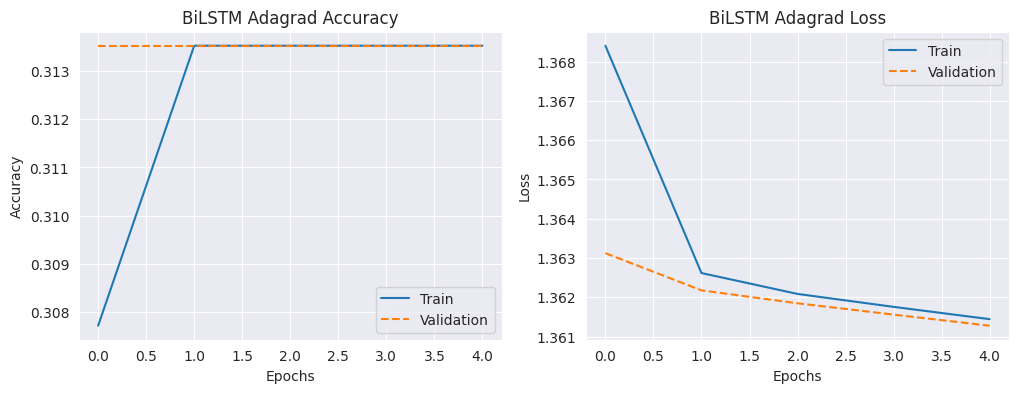

In [ ]:
# Train BiLSTM model
for name, opt_class in optimizer_classes.items():
    print(f"Training BiLSTM with {name}...")

    bilstm = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(128)),
        Dense(y_train_cat.shape[1], activation='softmax')
    ])

    opt = opt_class() 
    bilstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = bilstm.fit(
        X_train_pad,
        y_train_cat,
        epochs=10,
        batch_size=64,
        validation_data=(X_test_pad, y_test_cat),
        verbose=1,
        callbacks=[early_stopping]
    )

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train")
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label="Validation")
    plt.title(f"BiLSTM {name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], linestyle='dashed', label="Validation")
    plt.title(f"BiLSTM {name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Model Evaluation and Its Outputs

**BiLSTM (Bidirectional Long Short-Term Memory):**    
Architecture: The BiLSTM model includes an embedding layer, a bidirectional LSTM layer, and a dense output layer.    
**Best Accuracy:**   
 - Adam: 91.23% (Training accuracy), 84.19% (Validation accuracy)
 - SGD: 32.29% (Training accuracy), 32.17% (Validation accuracy)
 - Adagrad: 31.27% (Training accuracy), 31.35% (Validation accuracy)    

Similar to the FFNN, the BiLSTM model performed best with the Adam optimizer, showing a significant improvement in training accuracy.    

<br>

<hr>

# **Final Report**

## 1. **Project Overview**
The project aims to classify sentiments in social media posts related to video games using **natural language processing (NLP)** and **machine learning** techniques. The dataset, consisting of tweets labeled with different sentiments (**positive**, **negative**, **neutral**, **irrelevant**), was sourced from Twitter and preprocessed for analysis. The goal is to analyze these tweets to detect sentiment and understand the relationship between sentiment and the respective game brands mentioned in the posts. Several models, including **Feedforward Neural Networks (FFNN)**, **Gated Recurrent Units (GRU)**, and **Bidirectional Long Short-Term Memory Networks (BiLSTM)**, were trained to predict sentiment based on the cleaned and processed textual data.

<br>

## 2. **Data Preprocessing**

Data preprocessing plays a crucial role in preparing the raw text for machine learning models. The key steps taken in the preprocessing pipeline were:

### 2.1 **Text Cleaning**
The first step was to clean the raw textual data to improve the model's performance. The cleaning function:
- **Expanded contractions**: Common contractions like "won't" to "will not" were expanded for better model comprehension.
- **Removed URLs and special characters**: URLs were eliminated as they do not contribute to sentiment, and special characters were filtered out, keeping only the relevant punctuation.
- **Normalized punctuation**: Repeated punctuation (e.g., "!!" to "!") was standardized to ensure consistency.
- **Lowercase conversion**: All text was converted to lowercase to reduce the complexity of the vocabulary.
- **Emojis removal**: Emojis were removed as they might not provide relevant insights for sentiment analysis in this context.

### 2.2 **SpaCy Preprocessing**
Following the initial cleaning, **SpaCy's preprocessing** was used to:
- **Lemmatize** the words (converting words to their base form) to reduce the vocabulary size.
- **Remove stop words** (common words like “the”, “and”, etc.) and **punctuation**, which do not add value for the sentiment analysis.

This process ensured that only meaningful words remained for model training.

<br>

## 3. **Model Development**

### 3.1 **Feedforward Neural Networks (FFNN)**
The FFNN model was the first model trained for this project. This simple neural network architecture consists of:
- **Embedding layer**: Used for converting words into dense vectors that capture semantic meanings.
- **Flatten layer**: Transforms the 2D embedding output into a 1D vector.
- **Dense layers**: Two fully connected layers, with the final one using a **softmax** activation for multi-class classification.

**Results**:
- Best accuracy with **SGD**: 32.74% (training), 32.63% (validation)
- Best accuracy with **Adam**: 94.62% (training), 84.58% (validation)
- Best accuracy with **Adagrad**: 31.96% (training), 31.36% (validation)

**Findings**:
The **Adam optimizer** yielded the best performance among all, significantly outperforming both **SGD** and **Adagrad**. The model demonstrated high accuracy on training data but had a noticeable drop in validation accuracy, suggesting possible overfitting.

<br>

### 3.2 **Gated Recurrent Unit (GRU)**
The GRU model was designed to handle sequential data, leveraging the GRU layer for better memory retention of previous inputs.
- **Embedding layer**: Similar to FFNN, this layer maps words into dense vectors.
- **GRU layer**: The GRU unit helps capture long-term dependencies in text.
- **Dense output layer**: For sentiment classification.

**Results**:
- Best accuracy with **SGD**: 31.27% (training), 31.35% (validation)
- Best accuracy with **Adam**: 31.20% (training), 31.35% (validation)
- Best accuracy with **Adagrad**: 31.27% (training), 31.35% (validation)

**Findings**:
Despite its suitability for sequence data, the GRU model failed to achieve high accuracy. The performance was relatively poor across all optimizers, with the validation accuracy not surpassing 31%, indicating that the model struggled to generalize well.

<br>

### 3.3 **Bidirectional Long Short-Term Memory (BiLSTM)**
The BiLSTM model was implemented to address the sequence modeling task more effectively. Unlike GRU, BiLSTM benefits from learning from both the past and future context in the sequence.
- **Bidirectional LSTM layer**: This layer allows the network to consider both previous and future context for better sequence understanding.
- **Dense output layer**: For final sentiment classification.

**Results**:
- Best accuracy with **SGD**: 32.29% (training), 32.17% (validation)
- Best accuracy with **Adam**: 91.23% (training), 84.19% (validation)
- Best accuracy with **Adagrad**: 31.27% (training), 31.35% (validation)

**Findings**:
The **BiLSTM model with Adam** optimizer showed promising results, closely matching the FFNN's performance but with a more sophisticated architecture for handling sequential data. However, like the FFNN, it exhibited overfitting with training accuracy much higher than validation accuracy.

<br>

## 4. **Model Comparison and Insights**

### 4.1 **Key Insights**
- The **FFNN model with Adam** achieved the highest performance across all models, with an 84.58% validation accuracy. However, this model still showed signs of **overfitting**, as seen in the significant gap between training and validation accuracy.
- Both **GRU** and **BiLSTM** models struggled to surpass the performance of FFNN, especially in terms of validation accuracy. Despite their advantages in handling sequential data, these models failed to generalize effectively in this specific dataset.
- The **SGD optimizer** consistently underperformed across all model architectures, suggesting that it was less suitable for this specific NLP task compared to **Adam** and **Adagrad**.

### 4.2 **Overfitting Concern**
Across the models, **overfitting** was observed, particularly with the FFNN and BiLSTM models. Overfitting occurs when the model learns to perform well on the training data but fails to generalize to new, unseen data. This was evident as the validation accuracy was consistently lower than the training accuracy.

### 4.3 **Future Directions**
To address overfitting, future improvements could include:
- **Regularization techniques**: Adding **dropout layers** or using **L2 regularization** to prevent overfitting.
- **Hyperparameter tuning**: Optimizing the number of layers, the number of units in each layer, and the learning rate for better generalization.
- **Data augmentation**: Using techniques like **paraphrasing** or adding **noise** to the text data to generate more training samples and reduce model bias.

<br>

## 5. **Conclusion**
This project demonstrates the importance of **data preprocessing** and model selection for **sentiment classification** tasks in **NLP**. The **FFNN with Adam optimizer** showed the best results, while the **GRU and BiLSTM models** underperformed despite their theoretical advantages. Further tuning and adjustments to the model architecture, along with regularization techniques, will be necessary to improve the generalization and performance of these models in future iterations.





<br>

# References:
- https://spacy.io/usage/processing-pipelines/
- https://realpython.com/tutorials/best-practices/
- https://realpython.com/tutorials/machine-learning/
- https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
- https://pandas.pydata.org/pandas-docs/stable/user_guide/style_render.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.style.background_gradient.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.set_table_styles.html
- https://harvard-iacs.github.io/2022-CS109B/pages/materials.html#Feed%20forward%20neural%20network
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU